# Classification

This notebook presents example usage of package for solving classification problem on `seismic-bumps` dataset. You can access dataset [here](https://raw.githubusercontent.com/adaa-polsl/RuleKit/master/data/seismic-bumps/seismic-bumps.arff).

This tutorial will cover topics such as:   
- training model   
- changing model hyperparameters   
- hyperparameters tuning   
- calculating metrics for model    
- getting RuleKit inbuilt   

## Install dependencies

In [ ]:
%pip install matplotlib

## Summary of the dataset

In [2]:
import pandas as pd
from rulekit.arff import read_arff

DATASET_URL: str = (
    'https://raw.githubusercontent.com/'
    'adaa-polsl/RuleKit/refs/heads/master/data/seismic-bumps/'
    'seismic-bumps.arff'
)

df_full: pd.DataFrame = read_arff(DATASET_URL)
df_full['class'] = df_full['class'].astype(int)
df_full.describe()

,genergy,gimpuls,goenergy,goimpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,senergy,maxenergy,class
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.0,2584.0,2584.0,2584.000000,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,0.0,0.0,0.0,4975.270898,4278.850619,0.065789
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,0.0,0.0,0.0,20450.833222,19357.454882,0.247962
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,2600.000000,2000.000000,0.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,0.0,0.0,0.0,402000.000000,400000.000000,1.000000


### Decision class distribution

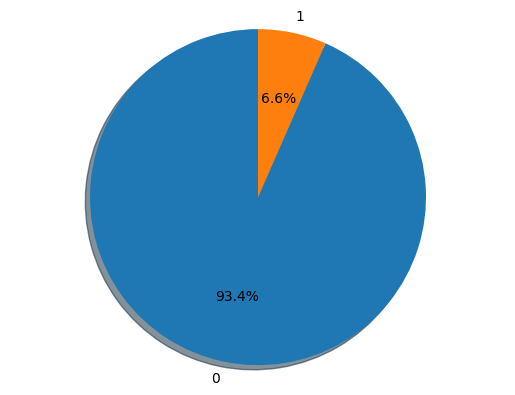

In [3]:
import matplotlib.pyplot as plt

groups = df_full['class'].value_counts()
sizes = [groups[0], groups[1]]
labels = [str(e) for e in groups.index]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

## Helper function for calculating metrics

In [4]:
import math
from sklearn import metrics
import numpy as np
from rulekit.classification import RuleClassifier


X: pd.DataFrame = df_full.drop(['class'], axis=1)
y: pd.Series = df_full['class']


def get_prediction_metrics(
    measure: str,
    y_pred: np.ndarray,
    y_true: pd.Series,
    classification_metrics: dict
) -> tuple[pd.DataFrame, np.ndarray]:
    confusion_matrix: np.ndarray = metrics.confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix.ravel()
    sensitivity: float = tp / (tp + fn)
    specificity: float = tn / (tn + fp)
    npv: float = tn / (tn + fn)
    ppv: float = tp / (tp + fp)

    dictionary = {
        'Measure': measure,
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'Kappa': metrics.cohen_kappa_score(y_true, y_pred),
        'Balanced accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Logistic loss': metrics.log_loss(y_true, y_pred),
        'Precision': metrics.log_loss(y_true, y_pred),
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'NPV': npv,
        'PPV': ppv,
        'psep': ppv + npv - 1,
        'Fall-out': fp / (fp + tn),
        "Youden's J statistic": sensitivity + specificity - 1,
        'Lift': (tp / (tp + fp)) / ((tp + fn) / (tp + tn + fp + fn)),
        'F-measure': 2 * tp / (2 * tp + fp + fn),
        'Fowlkes-Mallows index': metrics.fowlkes_mallows_score(y_true, y_pred),
        'False positive': fp,
        'False negative': fn,
        'True positive': tp,
        'True negative': tn,
        'Rules per example': classification_metrics['rules_per_example'],
        'Voting conflicts': classification_metrics['voting_conflicts'],
        'Geometric mean': math.sqrt(specificity * sensitivity),
        'Geometric mean': math.sqrt(specificity * sensitivity),
    }
    return pd.DataFrame.from_records([dictionary], index='Measure'), confusion_matrix


def get_ruleset_stats(
    measure: str,
    model: RuleClassifier
) -> pd.DataFrame:
    return pd.DataFrame.from_records(
        [{'Measure': measure, **model.stats.__dict__}],
        index='Measure'
    )

## Rule induction on full dataset

In [5]:
from rulekit.classification import RuleClassifier
from rulekit.rules import RuleSet, ClassificationRule
from rulekit.params import Measures
from IPython.display import display

# C2
clf = RuleClassifier(
    induction_measure=Measures.C2,
    pruning_measure=Measures.C2,
    voting_measure=Measures.C2,
)
clf.fit(X, y)
c2_ruleset: RuleSet[ClassificationRule] = clf.model
prediction, classification_metrics = clf.predict(X, return_metrics=True)

prediction_metric, c2_confusion_matrix = get_prediction_metrics('C2', prediction, y, classification_metrics)
model_stats = get_ruleset_stats('C2', clf.model)

# Correlation
clf = RuleClassifier(
    induction_measure=Measures.Correlation,
    pruning_measure=Measures.Correlation,
    voting_measure=Measures.Correlation,
)
clf.fit(X, y)
corr_ruleset: RuleSet[ClassificationRule] = clf.model
prediction, classification_metrics = clf.predict(X, return_metrics=True)

tmp, corr_confusion_matrix = get_prediction_metrics('Correlation', prediction, y, classification_metrics)
prediction_metric = pd.concat([prediction_metric, tmp])
model_stats = pd.concat([model_stats, get_ruleset_stats('Correlation', clf.model)])

# RSS
clf = RuleClassifier(
    induction_measure=Measures.RSS,
    pruning_measure=Measures.RSS,
    voting_measure=Measures.RSS,
)
clf.fit(X, y)
rss_ruleset: RuleSet[ClassificationRule] = clf.model
prediction, classification_metrics = clf.predict(X, return_metrics=True)
tmp, rss_confusion_matrix = get_prediction_metrics('RSS', prediction, y, classification_metrics)
prediction_metric = pd.concat([prediction_metric, tmp])
model_stats = pd.concat([model_stats, get_ruleset_stats('RSS', clf.model)])

display(model_stats)
display(prediction_metric)

print('Confusion matrix - C2')
display(pd.DataFrame(c2_confusion_matrix))

print('Confusion matrix - Correlation')
display(pd.DataFrame(corr_confusion_matrix))

print('Confusion matrix - RSS')
display(pd.DataFrame(rss_confusion_matrix))

,time_total_s,time_growing_s,time_pruning_s,rules_count,conditions_per_rule,induced_conditions_per_rule,avg_rule_coverage,avg_rule_precision,avg_rule_quality,pvalue,FDR_pvalue,FWER_pvalue,fraction_significant,fraction_FDR_significant,fraction_FWER_significant
Measure,,,,,,,,,,,,,,,
C2,1.218550,1.036229,0.111458,35,4.742857,22.142857,0.259410,0.670793,0.322125,0.005729,0.005879,0.010640,0.971429,0.971429,0.885714
Correlation,0.471475,0.339709,0.123223,21,5.142857,51.666667,0.306612,0.469157,0.201772,0.016841,0.017345,0.026655,0.904762,0.904762,0.857143
RSS,1.514044,1.327209,0.171176,14,3.714286,64.428571,0.473795,0.484564,0.253249,0.041892,0.044068,0.068063,0.785714,0.785714,0.714286


,Accuracy,MAE,Kappa,Balanced accuracy,Logistic loss,Precision,Sensitivity,Specificity,NPV,PPV,...,Lift,F-measure,Fowlkes-Mallows index,False positive,False negative,True positive,True negative,Rules per example,Voting conflicts,Geometric mean
Measure,,,,,,,,,,,,,,,,,,,,,
C2,0.932663,0.067337,0.433613,0.709693,2.427088,2.427088,0.452941,0.966446,0.961665,0.487342,...,7.407595,0.469512,0.928703,81,93,77,2333,9.079334,2146.0,0.661622
Correlation,0.827399,0.172601,0.246689,0.729909,6.221157,6.221157,0.617647,0.842171,0.969018,0.216049,...,3.283951,0.320122,0.823757,381,65,105,2033,6.438854,1993.0,0.721224
RSS,0.788313,0.211687,0.207458,0.725394,7.629984,7.629984,0.652941,0.797846,0.970277,0.185309,...,2.816694,0.288687,0.789800,488,59,111,1926,6.633127,2085.0,0.721766


Confusion matrix - C2


,0,1
0,2333,81
1,93,77


Confusion matrix - Correlation


,0,1
0,2033,381
1,65,105


Confusion matrix - RSS


,0,1
0,1926,488
1,59,111


### C2 Measure generated rules

In [6]:
for rule in c2_ruleset.rules:
    print(rule)

IF gimpuls = (-inf, 32.50) THEN class = {0}
IF nbumps = (-inf, 0.50) AND goenergy = <-84.50, inf) AND goimpuls = (-inf, -0.50) AND genergy = (-inf, 13675) THEN class = {0}
IF genergy = (-inf, 17640) AND nbumps = (-inf, 0.50) AND goenergy = <-84.50, inf) THEN class = {0}
IF genergy = <1625, 17640) AND maxenergy = (-inf, 3500) AND gimpuls = (-inf, 772.50) THEN class = {0}
IF shift = {N} AND nbumps = (-inf, 0.50) AND goenergy = <-73.50, inf) THEN class = {0}
IF shift = {N} AND senergy = (-inf, 6150) AND genergy = <1865, inf) AND goimpuls = (-inf, 230.50) THEN class = {0}
IF senergy = (-inf, 550) AND gimpuls = (-inf, 380.50) AND goimpuls = (-inf, 96.50) AND goenergy = (-inf, 118) THEN class = {0}
IF senergy = (-inf, 550) AND genergy = (-inf, 31790) AND goenergy = <-84.50, 114.50) THEN class = {0}
IF senergy = (-inf, 550) AND goenergy = <-84.50, 87.50) AND gimpuls = (-inf, 1342.50) AND goimpuls = (-inf, 96) THEN class = {0}
IF senergy = (-inf, 550) AND goimpuls = (-inf, 233.50) THEN class =

### Correlation Measure generated rules

In [7]:
for rule in corr_ruleset.rules:
    print(rule)

IF nbumps = (-inf, 1.50) AND gimpuls = (-inf, 1252.50) THEN class = {0}
IF nbumps = (-inf, 2.50) AND gimpuls = (-inf, 1331) AND goimpuls = (-inf, 312) AND nbumps5 = (-inf, 0.50) THEN class = {0}
IF nbumps = (-inf, 2.50) THEN class = {0}
IF gimpuls = (-inf, 1253.50) AND nbumps3 = (-inf, 2.50) AND nbumps = (-inf, 7) THEN class = {0}
IF nbumps4 = (-inf, 2.50) THEN class = {0}
IF nbumps2 = <0.50, 2.50) AND maxenergy = <1500, inf) AND senergy = (-inf, 36050) AND nbumps3 = <0.50, 4.50) AND goimpuls = <-34, 95) AND genergy = (-inf, 662435) AND gimpuls = <994.50, 1959) THEN class = {1}
IF nbumps2 = <0.50, inf) AND maxenergy = <1500, inf) AND goimpuls = <-55, 95) AND nbumps = (-inf, 6.50) AND genergy = <61250, 662435) AND goenergy = (-inf, 96) AND nbumps3 = <0.50, inf) AND gimpuls = <712, 2257.50) AND senergy = (-inf, 31100) THEN class = {1}
IF nbumps2 = <0.50, inf) AND genergy = <58310, 934630) AND goenergy = (-inf, 186) AND senergy = (-inf, 40650) AND maxenergy = <1500, inf) AND gimpuls = <53

### RSS Measure generated rules

In [8]:
for rule in rss_ruleset.rules:
    print(rule)

IF nbumps = (-inf, 1.50) AND genergy = (-inf, 126350) THEN class = {0}
IF nbumps = (-inf, 1.50) AND gimpuls = (-inf, 2168) AND goimpuls = (-inf, 96.50) THEN class = {0}
IF genergy = (-inf, 44750) AND nbumps3 = (-inf, 2.50) AND goenergy = (-inf, 105.50) THEN class = {0}
IF gimpuls = (-inf, 725.50) AND nbumps3 = (-inf, 3.50) AND nbumps4 = (-inf, 2.50) AND goimpuls = (-inf, 117) AND goenergy = <-88.50, inf) THEN class = {0}
IF nbumps2 = (-inf, 1.50) AND nbumps = (-inf, 4.50) THEN class = {0}
IF goimpuls = (-inf, 312) AND nbumps5 = (-inf, 0.50) AND goenergy = <-88.50, inf) THEN class = {0}
IF gimpuls = <521.50, inf) AND genergy = <57680, inf) THEN class = {1}
IF nbumps = <1.50, inf) THEN class = {1}
IF senergy = <550, inf) AND shift = {W} AND genergy = <10495, inf) THEN class = {1}
IF nbumps = <0.50, inf) AND goimpuls = <-74.50, inf) AND gimpuls = <32.50, inf) AND goenergy = <-78.50, 124.50) THEN class = {1}
IF genergy = <34315, 49585) AND ghazard = {a} AND gimpuls = <396, 1445.50) AND goe

## Stratified K-Folds cross-validation

In [9]:
from IPython.display import display
from sklearn.model_selection import StratifiedKFold

N_SPLITS: int = 10

skf = StratifiedKFold(n_splits=10)

In [10]:
c2_ruleset_stats = pd.DataFrame()
c2_prediction_metrics = pd.DataFrame()
c2_confusion_matrix = np.array([[0.0, 0.0], [0.0, 0.0]])

for train_index, test_index in skf.split(X, y):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = RuleClassifier(
        induction_measure=Measures.C2,
        pruning_measure=Measures.C2,
        voting_measure=Measures.C2,
    )
    clf.fit(x_train, y_train)
    c2_ruleset = clf.model
    prediction, classification_metrics = clf.predict(x_test, return_metrics=True)
    tmp, confusion_matrix = get_prediction_metrics('C2', prediction, y_test, classification_metrics)
    
    c2_prediction_metrics = pd.concat([c2_prediction_metrics, tmp])
    c2_ruleset_stats = pd.concat([c2_ruleset_stats, get_ruleset_stats('C2', c2_ruleset)])
    c2_confusion_matrix += confusion_matrix

c2_confusion_matrix /= N_SPLITS

C:\Users\cezar\AppData\Local\Temp\ipykernel_13196\4002598548.py:22: RuntimeWarning: invalid value encountered in scalar divide
  ppv: float = tp / (tp + fp)
C:\Users\cezar\AppData\Local\Temp\ipykernel_13196\4002598548.py:39: RuntimeWarning: invalid value encountered in scalar divide
  'Lift': (tp / (tp + fp)) / ((tp + fn) / (tp + tn + fp + fn)),
C:\Users\cezar\AppData\Local\Temp\ipykernel_13196\4002598548.py:22: RuntimeWarning: invalid value encountered in scalar divide
  ppv: float = tp / (tp + fp)
C:\Users\cezar\AppData\Local\Temp\ipykernel_13196\4002598548.py:39: RuntimeWarning: invalid value encountered in scalar divide
  'Lift': (tp / (tp + fp)) / ((tp + fn) / (tp + tn + fp + fn)),


Rules characteristics 

In [11]:
display(c2_ruleset_stats.mean())

time_total_s                    0.292132
time_growing_s                  0.227262
time_pruning_s                  0.047455
rules_count                    34.200000
conditions_per_rule             4.720378
induced_conditions_per_rule    21.124536
avg_rule_coverage               0.239541
avg_rule_precision              0.690010
avg_rule_quality                0.337021
pvalue                          0.014757
FDR_pvalue                      0.015234
FWER_pvalue                     0.030014
fraction_significant            0.909792
fraction_FDR_significant        0.909792
fraction_FWER_significant       0.872710
dtype: float64

Rules evaluation (average)

In [12]:
display(c2_prediction_metrics.mean())

Accuracy                   0.855063
MAE                        0.144937
Kappa                      0.107556
Balanced accuracy          0.567020
Logistic loss              5.224070
Precision                  5.224070
Sensitivity                0.235294
Specificity                0.898747
NPV                        0.945594
PPV                        0.495355
psep                       0.443788
Fall-out                   0.101253
Youden's J statistic       0.134041
Lift                       7.520255
F-measure                  0.145015
Fowlkes-Mallows index      0.870605
False positive            24.500000
False negative            13.000000
True positive              4.000000
True negative            216.900000
Rules per example          7.871479
Voting conflicts         179.000000
Geometric mean             0.344832
dtype: float64

Confusion matrix (average)

In [13]:
display(pd.DataFrame(c2_confusion_matrix))

,0,1
0,216.9,24.5
1,13.0,4.0


## Hyperparameters tuning

This one gonna take a while...

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from rulekit.params import Measures

N_SPLITS: int = 3

# define models and parameters
model = RuleClassifier()
minsupp_new = range(3, 15, 2)
measures_choice = [Measures.C2, Measures.RSS, Measures.WeightedLaplace, Measures.Correlation]

# define grid search
grid = {
    'minsupp_new': minsupp_new, 
    'induction_measure': measures_choice, 
    'pruning_measure': measures_choice, 
    'voting_measure': measures_choice
}
cv = StratifiedKFold(n_splits=N_SPLITS)
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=grid, 
    cv=cv, 
    scoring='balanced_accuracy', 
    n_jobs=3
)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best BAC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best BAC: 0.626780 using {'induction_measure': <Measures.WeightedLaplace: 'WeightedLaplace'>, 'minsupp_new': 5, 'pruning_measure': <Measures.RSS: 'RSS'>, 'voting_measure': <Measures.WeightedLaplace: 'WeightedLaplace'>}


## Building model with tuned hyperparameters

### Split dataset to train and test (80%/20%).

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


clf = RuleClassifier(**grid_result.best_params_)
clf.fit(X_train, y_train)
ruleset: RuleSet[ClassificationRule] = clf.model
ruleset_stats = get_ruleset_stats('Best', ruleset)

Rules evaluation

In [21]:
display(ruleset_stats.mean())

time_total_s                    0.173054
time_growing_s                  0.120460
time_pruning_s                  0.029986
rules_count                    29.000000
conditions_per_rule             2.689655
induced_conditions_per_rule    15.310345
avg_rule_coverage               0.491183
avg_rule_precision              0.736226
avg_rule_quality                1.309334
pvalue                          0.019831
FDR_pvalue                      0.019993
FWER_pvalue                     0.024284
fraction_significant            0.931034
fraction_FDR_significant        0.931034
fraction_FWER_significant       0.931034
dtype: float64

### Validate model on test dataset

In [22]:
prediction, classification_metrics = clf.predict(X_test, return_metrics=True)
prediction_metrics, confusion_matrix = get_prediction_metrics('Best', prediction, y_test, classification_metrics)

display(prediction_metrics.mean())
display(pd.DataFrame(confusion_matrix))

Accuracy                   0.808511
MAE                        0.191489
Kappa                      0.170010
Balanced accuracy          0.679398
Logistic loss              6.901976
Precision                  6.901976
Sensitivity                0.533333
Specificity                0.825462
NPV                        0.966346
PPV                        0.158416
psep                       0.124762
Fall-out                   0.174538
Youden's J statistic       0.358795
Lift                       2.730033
F-measure                  0.244275
Fowlkes-Mallows index      0.809997
False positive            85.000000
False negative            14.000000
True positive             16.000000
True negative            402.000000
Rules per example         14.034816
Voting conflicts         360.000000
Geometric mean             0.663511
dtype: float64

,0,1
0,402,85
1,14,16
